In [53]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm


class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, d, kd):
        super(PINN, self).__init__()
        # Define neural network layers
        self.layers = nn.ModuleList(
            [
                (
                    nn.Linear(input_size if i == 0 else hidden_size, hidden_size)
                    if i % 2 == 0
                    else nn.Tanh()
                )
                for i in range(20)
            ]
        )
        # Output layer for concentration (C)
        self.layers.append(nn.Linear(hidden_size, output_size))

        # Learnable parameters: D and Kd (initially set as trainable parameters)
        self.D = nn.Parameter(
            torch.tensor([10.0], dtype=torch.float32, requires_grad=True)
        )  # Diffusion coefficient
        # self.Kd = nn.Parameter(
        #     torch.tensor([10.0], dtype=torch.float32, requires_grad=True)
        # )  # Sorption coefficient
        # self.D = d
        self.Kd = kd

        # Loss function and optimizer
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x):
        # Feedforward pass to get concentration profile
        for layer in self.layers:
            x = layer(x)
        return x

    def residual_loss(self, xtrain):
        g = xtrain.clone()
        g.requires_grad = True
        u_pred = self.forward(g)  # Predicted concentration

        # Compute gradients for the residuals
        u_x_t = torch.autograd.grad(
            u_pred,
            g,
            torch.ones([g.shape[0], 1]).to("cuda"),
            retain_graph=True,
            create_graph=True,
        )[0]
        u_xx_tt = torch.autograd.grad(
            u_x_t, g, torch.ones(g.shape).to("cuda"), create_graph=True
        )[0]

        # Diffusion term: u_xx (second spatial derivative)
        u_xx = u_xx_tt[:, [0]]

        # Physics-informed residual (diffusion-sorption-reaction equation)
        residual = u_x_t[:, [1]] - (self.D / (1 + self.Kd)) * u_xx

        return self.loss(
            residual, torch.zeros_like(residual).to("cuda")
        )  # Residual should be zero

    def total_loss(self, xtrain, utrain):
        # Data loss: Compare predicted concentration to true concentration
        data_loss = self.loss(self.forward(xtrain), utrain)

        # Residual loss: Physics-informed
        residual_loss = self.residual_loss(xtrain)

        return data_loss, residual_loss, data_loss + residual_loss

    def train_model(self, xtrain, utrain, epochs=1000):
        for epoch in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            a, b, loss = self.total_loss(xtrain, utrain)
            loss.backward()
            self.optimizer.step()
            if epoch % 200 == 0:
                print(
                    f"Epoch {epoch}, Loss {loss.item()}, Data Loss {a.item()}, Residual Loss {b.item()}, D {self.D.item()}"
                )

In [54]:
import h5py

Nx = 100
Nt = 201

with h5py.File("diff_sorp.h5", "r") as f:
    dtrue = f["1"]["D"][()]
    ktrue = f["1"]["Kd"][()]
    C_all = f["1"]["data"][:]
    f.close()
# Create input (x, t) and output (C) tensors
x = np.linspace(0, 10, Nx)
t = np.linspace(0, 1, Nt)
X, T = np.meshgrid(x, t)
X_train = torch.tensor(
    np.hstack((X.flatten()[:, None], T.flatten()[:, None])), dtype=torch.float32
).to("cuda")
C_train = torch.tensor(C_all.flatten()[:, None], dtype=torch.float32).to("cuda")
X_train.shape, C_train.shape

(torch.Size([20100, 2]), torch.Size([20100, 1]))

In [55]:
dtrue, ktrue

(82.44376791378382, 92.0820718580985)

In [56]:
idx = np.random.choice(Nx * Nt, 10000, replace=False)
xtrain = X_train[idx]
ctrain = C_train[idx]
xtrain.shape, ctrain.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

In [57]:
model = PINN(2, 20, 1, dtrue, ktrue).to("cuda")
model.train_model(xtrain, ctrain, epochs=10000)

  0%|          | 35/10000 [00:00<00:57, 173.44it/s]

Epoch 0, Loss 0.1486700177192688, Data Loss 0.1486700028181076, Residual Loss 1.4683240401325293e-08, D 10.000001907348633


  2%|▏         | 226/10000 [00:01<00:51, 189.79it/s]

Epoch 200, Loss 0.09214071184396744, Data Loss 0.09213516861200333, Residual Loss 5.542055987461936e-06, D 10.018521308898926


  4%|▍         | 439/10000 [00:02<00:47, 202.32it/s]

Epoch 400, Loss 0.043837450444698334, Data Loss 0.042598187923431396, Residual Loss 0.001239262637682259, D 10.072480201721191


  6%|▋         | 635/10000 [00:03<00:44, 208.24it/s]

Epoch 600, Loss 0.016205137595534325, Data Loss 0.015617374330759048, Residual Loss 0.0005877629155293107, D 10.100500106811523


  8%|▊         | 831/10000 [00:04<00:44, 208.27it/s]

Epoch 800, Loss 0.005763827357441187, Data Loss 0.005266652442514896, Residual Loss 0.0004971750313416123, D 10.114243507385254


 10%|█         | 1030/10000 [00:05<00:48, 185.29it/s]

Epoch 1000, Loss 0.004270282573997974, Data Loss 0.0037647741846740246, Residual Loss 0.0005055085057392716, D 10.101052284240723


 12%|█▏        | 1231/10000 [00:06<00:45, 192.09it/s]

Epoch 1200, Loss 0.0038798702880740166, Data Loss 0.003431067569181323, Residual Loss 0.0004488026606850326, D 10.111394882202148


 14%|█▍        | 1437/10000 [00:07<00:44, 193.12it/s]

Epoch 1400, Loss 0.003658947767689824, Data Loss 0.0032497947104275227, Residual Loss 0.0004091529699508101, D 10.138211250305176


 16%|█▋        | 1632/10000 [00:08<00:44, 187.08it/s]

Epoch 1600, Loss 0.0035063999239355326, Data Loss 0.0031294096261262894, Residual Loss 0.0003769903560169041, D 10.169303894042969


 18%|█▊        | 1823/10000 [00:09<00:44, 183.71it/s]

Epoch 1800, Loss 0.003392882877960801, Data Loss 0.003041590331122279, Residual Loss 0.0003512925759423524, D 10.199975967407227


 20%|██        | 2032/10000 [00:10<00:43, 184.66it/s]

Epoch 2000, Loss 0.00331399729475379, Data Loss 0.0029818713665008545, Residual Loss 0.0003321259282529354, D 10.229395866394043


 22%|██▏       | 2228/10000 [00:11<00:40, 192.64it/s]

Epoch 2200, Loss 0.003246019361540675, Data Loss 0.00292591517791152, Residual Loss 0.00032010427094064653, D 10.257577896118164


 24%|██▍       | 2430/10000 [00:12<00:40, 189.03it/s]

Epoch 2400, Loss 0.0032030974980443716, Data Loss 0.0028930953703820705, Residual Loss 0.00031000221497379243, D 10.284610748291016


 26%|██▌       | 2620/10000 [00:13<00:42, 172.58it/s]

Epoch 2600, Loss 0.003172104014083743, Data Loss 0.0028710097540169954, Residual Loss 0.0003010942891705781, D 10.310602188110352


 28%|██▊       | 2835/10000 [00:14<00:36, 195.74it/s]

Epoch 2800, Loss 0.0031490905676037073, Data Loss 0.002856368664652109, Residual Loss 0.0002927218738477677, D 10.335631370544434


 30%|███       | 3036/10000 [00:15<00:34, 202.91it/s]

Epoch 3000, Loss 0.003131384029984474, Data Loss 0.0028456873260438442, Residual Loss 0.00028569670394062996, D 10.359795570373535


 32%|███▏      | 3225/10000 [00:16<00:33, 202.57it/s]

Epoch 3200, Loss 0.003122504334896803, Data Loss 0.002845153445377946, Residual Loss 0.00027735080220736563, D 10.383190155029297


 34%|███▍      | 3430/10000 [00:17<00:35, 185.98it/s]

Epoch 3400, Loss 0.0031056462321430445, Data Loss 0.0028311137575656176, Residual Loss 0.000274532416369766, D 10.405939102172852


 36%|███▌      | 3621/10000 [00:19<00:34, 183.60it/s]

Epoch 3600, Loss 0.0030957397539168596, Data Loss 0.002825000789016485, Residual Loss 0.0002707389649003744, D 10.428163528442383


 38%|███▊      | 3830/10000 [00:20<00:33, 182.71it/s]

Epoch 3800, Loss 0.0030870542395859957, Data Loss 0.002819215413182974, Residual Loss 0.00026783879729919136, D 10.449967384338379


 40%|████      | 4023/10000 [00:21<00:32, 181.71it/s]

Epoch 4000, Loss 0.0030792655888944864, Data Loss 0.002813479630276561, Residual Loss 0.0002657859877217561, D 10.471430778503418


 42%|████▏     | 4237/10000 [00:22<00:29, 195.91it/s]

Epoch 4200, Loss 0.003072078339755535, Data Loss 0.0028080607298761606, Residual Loss 0.0002640174934640527, D 10.492646217346191


 44%|████▍     | 4429/10000 [00:23<00:26, 209.29it/s]

Epoch 4400, Loss 0.0030653714202344418, Data Loss 0.00280277943238616, Residual Loss 0.00026259198784828186, D 10.513636589050293


 46%|████▋     | 4635/10000 [00:24<00:28, 189.38it/s]

Epoch 4600, Loss 0.0030629790853708982, Data Loss 0.0027991950046271086, Residual Loss 0.00026378402253612876, D 10.534441947937012


 48%|████▊     | 4824/10000 [00:25<00:25, 205.45it/s]

Epoch 4800, Loss 0.0030530071817338467, Data Loss 0.002792586339637637, Residual Loss 0.00026042075478471816, D 10.555134773254395


 50%|█████     | 5041/10000 [00:26<00:24, 203.61it/s]

Epoch 5000, Loss 0.0030472290236502886, Data Loss 0.002787598641589284, Residual Loss 0.00025963029474951327, D 10.57573413848877


 52%|█████▏    | 5228/10000 [00:27<00:25, 189.44it/s]

Epoch 5200, Loss 0.0030415840446949005, Data Loss 0.002782647730782628, Residual Loss 0.0002589363430161029, D 10.596207618713379


 54%|█████▍    | 5437/10000 [00:28<00:21, 207.91it/s]

Epoch 5400, Loss 0.0030360824894160032, Data Loss 0.00277781393378973, Residual Loss 0.00025826855562627316, D 10.616616249084473


 56%|█████▋    | 5630/10000 [00:29<00:21, 200.47it/s]

Epoch 5600, Loss 0.003030847990885377, Data Loss 0.0027725473046302795, Residual Loss 0.0002583006280474365, D 10.636987686157227


 58%|█████▊    | 5833/10000 [00:30<00:22, 187.54it/s]

Epoch 5800, Loss 0.003025430953130126, Data Loss 0.002768474631011486, Residual Loss 0.00025695632211863995, D 10.657231330871582


 60%|██████    | 6037/10000 [00:31<00:20, 192.09it/s]

Epoch 6000, Loss 0.003020009258762002, Data Loss 0.0027633861172944307, Residual Loss 0.00025662319967523217, D 10.677449226379395


 62%|██████▏   | 6223/10000 [00:32<00:18, 208.14it/s]

Epoch 6200, Loss 0.0030146792996674776, Data Loss 0.002760338829830289, Residual Loss 0.00025434052804484963, D 10.697667121887207


 64%|██████▍   | 6429/10000 [00:33<00:18, 188.21it/s]

Epoch 6400, Loss 0.0030126171186566353, Data Loss 0.0027627036906778812, Residual Loss 0.00024991354439407587, D 10.71788501739502


 66%|██████▌   | 6624/10000 [00:34<00:17, 194.50it/s]

Epoch 6600, Loss 0.0030031732749193907, Data Loss 0.0027501413132995367, Residual Loss 0.00025303204893134534, D 10.738102912902832


 68%|██████▊   | 6824/10000 [00:35<00:16, 187.14it/s]

Epoch 6800, Loss 0.0029975695069879293, Data Loss 0.0027460516430437565, Residual Loss 0.0002515178930480033, D 10.758308410644531


 70%|███████   | 7034/10000 [00:36<00:16, 180.64it/s]

Epoch 7000, Loss 0.002991914749145508, Data Loss 0.00274195009842515, Residual Loss 0.00024996462161652744, D 10.778522491455078


 72%|███████▏  | 7232/10000 [00:37<00:14, 190.23it/s]

Epoch 7200, Loss 0.0029864334501326084, Data Loss 0.002738473005592823, Residual Loss 0.00024796041543595493, D 10.79874038696289


 74%|███████▍  | 7419/10000 [00:38<00:13, 197.57it/s]

Epoch 7400, Loss 0.002981878351420164, Data Loss 0.002738028299063444, Residual Loss 0.00024385000870097429, D 10.818958282470703


 76%|███████▌  | 7623/10000 [00:39<00:13, 179.83it/s]

Epoch 7600, Loss 0.002976302057504654, Data Loss 0.002730964682996273, Residual Loss 0.0002453373745083809, D 10.839176177978516


 78%|███████▊  | 7831/10000 [00:41<00:11, 190.73it/s]

Epoch 7800, Loss 0.002971821231767535, Data Loss 0.0027273311279714108, Residual Loss 0.00024449010379612446, D 10.859420776367188


 80%|████████  | 8035/10000 [00:42<00:10, 190.18it/s]

Epoch 8000, Loss 0.0029676659032702446, Data Loss 0.0027240740600973368, Residual Loss 0.000243591726757586, D 10.879798889160156


 82%|████████▏ | 8221/10000 [00:43<00:09, 187.03it/s]

Epoch 8200, Loss 0.0029638030100613832, Data Loss 0.002720869844779372, Residual Loss 0.00024293322348967195, D 10.90019416809082


 84%|████████▍ | 8422/10000 [00:44<00:07, 199.51it/s]

Epoch 8400, Loss 0.002960213692858815, Data Loss 0.0027180847246199846, Residual Loss 0.00024212889547925442, D 10.920591354370117


 86%|████████▋ | 8632/10000 [00:45<00:06, 203.63it/s]

Epoch 8600, Loss 0.002956847194582224, Data Loss 0.002714879345148802, Residual Loss 0.00024196776212193072, D 10.940984725952148


 88%|████████▊ | 8830/10000 [00:46<00:07, 156.98it/s]

Epoch 8800, Loss 0.002957524498924613, Data Loss 0.0027089565992355347, Residual Loss 0.0002485678414814174, D 10.961385726928711


 90%|█████████ | 9041/10000 [00:47<00:04, 193.75it/s]

Epoch 9000, Loss 0.002951072296127677, Data Loss 0.0027076362166553736, Residual Loss 0.00024343606492038816, D 10.981781959533691


 92%|█████████▏| 9222/10000 [00:48<00:04, 192.17it/s]

Epoch 9200, Loss 0.0029478261712938547, Data Loss 0.002707664156332612, Residual Loss 0.00024016205861698836, D 11.002032279968262


 94%|█████████▍| 9434/10000 [00:49<00:03, 183.60it/s]

Epoch 9400, Loss 0.002945102285593748, Data Loss 0.002705455757677555, Residual Loss 0.0002396465715719387, D 11.02225399017334


 96%|█████████▋| 9627/10000 [00:50<00:02, 183.79it/s]

Epoch 9600, Loss 0.002942497143521905, Data Loss 0.0027032564394176006, Residual Loss 0.0002392408059677109, D 11.042471885681152


 98%|█████████▊| 9826/10000 [00:51<00:00, 200.19it/s]

Epoch 9800, Loss 0.0029399225022643805, Data Loss 0.002701374003663659, Residual Loss 0.00023854855680838227, D 11.062689781188965


100%|██████████| 10000/10000 [00:52<00:00, 190.15it/s]


In [52]:
model.D.item()

10.687514305114746

tensor(-1.6507e-05)


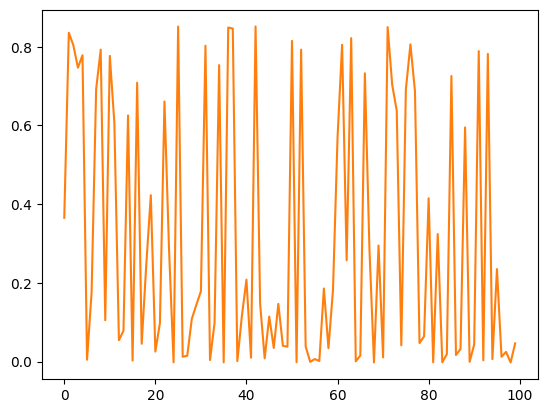

In [51]:
import matplotlib.pyplot as plt

with torch.no_grad():
    C_pred = model.forward(xtrain).cpu().numpy()
    C_pred = C_pred.reshape((Nx, 100))
    print(torch.mean(ctrain.cpu() - C_pred.flatten()))
    plt.plot(ctrain.cpu().numpy()[0], label="True")
    plt.plot(C_pred[0], label="Predicted")
    plt.show()